In [ ]:
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import qutip as qt
from quantum_logical import Pulse, DressedQuantumSystem
from quantum_logical.hamiltonian import QubitSNAILModule
from quantum_logical.mode import QubitMode, SNAILMode
from qutip import Options

from tqdm import tqdm
from scipy.optimize import minimize


opts = {"nsteps": 1e6, "atol": 1e-8, "rtol": 1e-6}
p_bar = qt.ui.TextProgressBar()  # None
p_bar = None

In [13]:
# Initial qubit frequencies and SNAIL frequency
freqs = np.array([5.06167, 4.54944, 4.16829])  # q1, q2, q3 frequencies
snail_freq = 4.27515  # SNAIL frequency

In [14]:
qubit_dim = 2
qubit1 = QubitMode(name="q1", dim=qubit_dim, freq=freqs[0])
qubit2 = QubitMode(name="q2", dim=qubit_dim, freq=freqs[1])
qubit3 = QubitMode(name="q3", dim=qubit_dim, freq=freqs[2])
qubits = [qubit1, qubit2, qubit3]
snail = SNAILMode(name="s", freq=snail_freq, g3=0.3, dim=10, T1=1e3, T2=5e2)

# define couplings so hybridizations are all equal
# g/delta = 0.1 for all qubits
g2_0 = 0.1 * np.abs(snail.freq - qubit1.freq)
g2_1 = 0.1 * np.abs(snail.freq - qubit2.freq)
g2_2 = 0.1 * np.abs(snail.freq - qubit3.freq)
_couplings = {
    frozenset([qubit1, snail]): g2_0,
    frozenset([qubit2, snail]): g2_1,
    frozenset([qubit3, snail]): g2_2,
}

qs = DressedQuantumSystem(
    qubits + [snail], couplings=_couplings, hamiltonian_cls=QubitSNAILModule
)

In [15]:
# create an initial state
# |0> \otimes |1> \otimes |0> \otimes |0>
psi0 = qs.prepare_approx_state([(qubit2, 1)])
rho0 = psi0 * psi0.dag()

Found overlap with eigenstate by 0.9946


In [16]:
# FIXME, main downside here is that we correctly want to define the action of
# the ancillae qubits as identity; but the action of the SNAIL should be undefined.
# This is because the action on SNAIL definitely won't be identity, but physically
# since SNAIL has short lifetime we know it will decay reliably to the ground state.
# However, our simulation doesn't necessarily include SNAIL loss channels. Therefore,
# the ideal action should be defined over the qubits only- not the SNAIL.

from qutip_qip.operations import iswap

desired_U = iswap()  # The iSWAP gate for a 2-qubit system

# Create isometries for qubit 1 and qubit 2 to extend the {g, e} subspace action to the full qubit space
identity_isometry = (
    qt.basis(qubit_dim, 0) * qt.basis(2, 0).dag()
    + qt.basis(qubit_dim, 1) * qt.basis(2, 1).dag()
)
identity_isometry = qt.tensor(identity_isometry, identity_isometry)

# Apply the isometry to extend the gate action to the complete system
extended_q1_q2 = identity_isometry * desired_U * identity_isometry.dag()

# Tensor with identity matrices for the remaining qubits and the SNAIL mode
# Skip the first two qubits as they're already included
# Skip the last index as it's the SNAIL mode
for mode in qs.modes[2:-1]:
    extended_q1_q2 = qt.tensor(extended_q1_q2, qt.qeye(mode.dim))

# The extended_iswap_q1_q2 now acts as the desired iSWAP gate on {g, e} of qubits 1 and 2, and as identity on the rest
desired_U = extended_q1_q2

# act on qubit space only
qubit_rho0 = rho0.ptrace(range(len(qubits)))
expected_qubit_rho = qt.Qobj(desired_U * qubit_rho0 * desired_U.dag())

In [17]:
# (undressed) expectation operators
e_ops = [qs.modes_num[m] for m in qs.modes]

# collapse operators
c_ops = []
# for mode in qs.modes:
#    c_ops.append(mode.collapse_operators(qs))

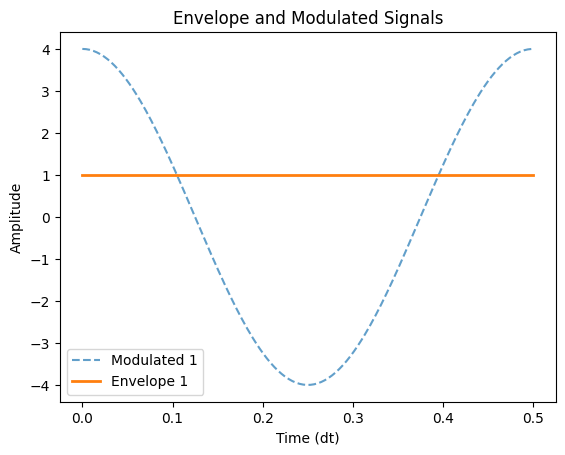

In [18]:
# Pulse preliminaries
wp = np.abs(qubit1.freq - qubit2.freq)
T = 2 * np.pi / wp
period_time = np.linspace(0, T, 250)  # a single period of the pulse
full_time = np.linspace(0, 250 * T, 1000)
args = {"shape": Pulse.constant}
pulse = Pulse(omega=wp, amp=4)
Pulse.plot_pulse([(pulse, args)], period_time)

In [19]:
# # Step 1 is to determine maximum Pulse amplitude
# # Can we use mesolve, sweep detuning and amplitude, output SNAIL population?
# def simulation_task(freq_amp_pair):
#     freq, amp = freq_amp_pair  # Unpack the tuple
#     pulse = Pulse(omega=freq, amp=amp)
#     H_pump = qs.hamiltonian.driven_term(snail_mode=snail, n_max=3.0)
#     solve_result = qt.mesolve(
#         H=[qs.hamiltonian.H0, [H_pump, pulse.drive]],
#         rho0=rho0,
#         tlist=full_time,
#         e_ops=[qs.modes_num[snail]],
#         c_ops=[snail.collapse_operators(qs)],
#         args=args,
#         options=opts,
#     )
#     return solve_result


# # Define a 2D list of frequencies and amplitudes to sweep,
# # frequencies will be detuned from the SNAIL's frequency
# # amplitude from 0 to 10
# N = 10
# detuning_rads = 2 * np.pi * np.linspace(-0.05, 0.05, N)  # Detuning in rad/s
# # flist = detuning_rads + snail.freq
# qs._initialize_dressed_freqs()
# flist = detuning_rads + wp
# alist = np.linspace(0, 40, N)

# # Prepare the parameters for parallel execution
# freq_amp_pairs = [(f, a) for f in flist for a in alist]

# # Run the simulations in parallel
# results = qt.parallel.parallel_map(simulation_task, freq_amp_pairs, progress_bar=True)

# # Process results
# populations = np.array([r.expect[0] for r in results])

In [20]:
# import numpy as np
# import matplotlib.pyplot as plt

# # Assuming populations.shape is (100, 250) where there are 100 experiments and 250 time steps
# # Compute the maximum population at each experiment
# max_populations = np.max(populations, axis=1)

# # Reshape the results into the shape of the amplitude and detuning grid
# max_population_matrix = max_populations.reshape(N, N)

# # Create meshgrid for the axes
# freq_mesh, amp_mesh = np.meshgrid(detuning_rads, alist, indexing="ij")

# # Plotting the heatmap
# plt.figure(figsize=(10, 8))
# heatmap = plt.pcolormesh(
#     freq_mesh, amp_mesh, max_population_matrix.T, shading="auto", cmap="viridis"
# )
# plt.colorbar(heatmap)
# plt.title("Maximum SNAIL Population by Frequency and Amplitude")
# plt.xlabel("Detuning (rad/s)")
# plt.ylabel("Amplitude")
# plt.show()

In [86]:
# # Calculate the propagator for T
# # assumes Ampltiude * envelope(t) is real/constant

# # v1 integrate Pulse H1(t) = [c e^{-iwt} - c^* e^{iwt}] from 0 to T
# U_t = (-1j * (H0 * T + H1 * (2 * c * 1j * (np.cos(wp * T) - 1) / wp))).expm()

# v2 integate the Pulse H1(t) = c * cos(wp * t) from 0 to T
# U_t = (-1j * (H0 * T + H1 * (c * np.sin(wp * T) / wp))).expm()
# # Apply the propagator to the initial state
# rho_t = qt.Qobj(U_t * rho0 * U_t.dag())

# # Calculate fidelities
# best_fidelity = qt.fidelity(rho_t, expected_rho)
# avg_gate_fidelity = qt.average_gate_fidelity(desired_U, U_t)
# print(f"Best fidelity: {best_fidelity:.4f} with c = {c:.4f}")
# print(f"Average gate fidelity: {avg_gate_fidelity:.4f}")

#####################################
# try using qutip's propagator
# turns out to be the same as our manual integral calculation
period_time = np.linspace(0, T, 250)  # a single period of the pulse
pulse = Pulse(omega=wp, amp=30)
H_pump = qs.hamiltonian.driven_term(snail_mode=snail, n_max=3.0)
H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
U_ts = qt.propagator(H, period_time, c_ops, args=args, options=opts)

# plot occupations for each time step inside the period
period_occupations = {mode: np.zeros(len(period_time)) for mode in qs.modes_num}
for idx, t in enumerate(period_time):
    rho_tt = qt.Qobj(U_ts[idx] * rho0 * U_ts[idx].dag())
    for mode in qs.modes_num:
        period_occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))

# next, propagate the state 1 period at a time
U_t = U_ts[-1]  # propagator for T=1 period
n_periods = 250
full_time = np.linspace(0, n_periods * T, n_periods)  # 250 periods of the pulse
occupations = {mode: np.zeros(len(full_time)) for mode in qs.modes_num}

rho_tt = rho0
for idx, t in tqdm(enumerate(full_time)):
    rho_tt = qt.Qobj(U_t * rho_tt * U_t.dag())
    for mode in qs.modes_num:
        # cast to reals, but we expect the imaginary part to be zero
        occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))

250it [00:00, 633.33it/s]


100%|██████████| 340/340 [00:00<00:00, 734.98it/s]


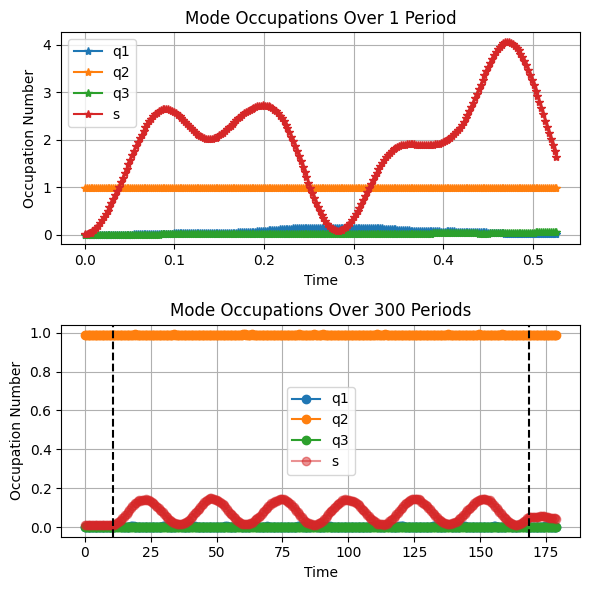

In [123]:
import numpy as np
import qutip as qt
from tqdm import tqdm

# Define the pulse frequency and amplitude
detuning = -0.1 * 2 * np.pi
pulse_frequency = np.abs(qubit1.freq - qubit2.freq) + detuning
T = 2 * np.pi / pulse_frequency
amplitude = 5.3

# Define pulse on and off configurations
pulse_on = Pulse(omega=pulse_frequency, amp=amplitude)
pulse_off = Pulse(omega=pulse_frequency, amp=0)

# Define Hamiltonians for pulse on and off
H_pump = qs.hamiltonian.driven_term(snail_mode=snail, n_max=None)
H_on = [qs.hamiltonian.H0, [H_pump, pulse_on.drive]]
H_off = [qs.hamiltonian.H0, [H_pump, pulse_off.drive]]

# Calculate propagators for on and off periods
period_time = np.linspace(0, T, 250)  # Duration of one pulse period
U_on = qt.propagator(H_on, period_time, c_ops, args=args, options=opts)[-1]
U_off = qt.propagator(H_off, period_time, c_ops, args=args, options=opts)[-1]

n_off_periods = 20
n_on_periods = 300
n_periods = 2 * n_off_periods + n_on_periods
full_time = np.linspace(
    0, n_periods * T, n_periods
)  # Time array for the whole simulation


# Initial state
rho_tt = rho0
# Occupation dictionaries for both dressed and undressed bases
occupations = {mode: np.zeros(n_periods) for mode in qs.modes_num}
und_occupations = {mode: np.zeros(n_periods) for mode in qs.modes_num}

# Simulate evolution: first off, then on, then off
for idx in tqdm(range(n_periods)):
    if idx < n_off_periods or idx >= n_off_periods + n_on_periods:
        U_t = U_off  # Pulse off
    else:
        U_t = U_on  # Pulse on

    rho_tt = qt.Qobj(U_t * rho_tt * U_t.dag())

    # Calculate occupations in the dressed basis
    for mode in qs.modes_num:
        occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))

# Plotting the occupations
import matplotlib.pyplot as plt

# Assuming qs.modes_num and other variables are already defined and calculated

# Setup the figure and axes for subplots
fig, axs = plt.subplots(2, 1, figsize=(6, 6))

# Plotting fine-grained evolution within one period
for mode, occ in period_occupations.items():
    axs[0].plot(period_time, occ, label=mode.name, marker="*")
axs[0].set_title("Mode Occupations Over 1 Period")
axs[0].set_xlabel("Time")
axs[0].set_ylabel("Occupation Number")
axs[0].legend()
axs[0].grid(True)

# Plotting full time evolution over n_periods
for mode, occ in occupations.items():
    alpha = 0.5 if mode is snail else 1.0
    axs[1].plot(full_time, occ, label=mode.name, marker="o", alpha=alpha)
axs[1].set_title(f"Mode Occupations Over {n_on_periods} Periods")
axs[1].set_xlabel("Time")
axs[1].set_ylabel("Occupation Number")
axs[1].legend()
# put vertical lines to indicate on and off periods
axs[1].axvline(n_off_periods * T, color="black", linestyle="--")
axs[1].axvline((n_off_periods + n_on_periods) * T, color="black", linestyle="--")
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [131]:
import numpy as np
import qutip as qt
from tqdm import tqdm
import matplotlib.pyplot as plt


def propagate(
    pulse_frequency,
    amplitude,
    snail,
    qs,
    rho0,
    c_ops,
    args,
    opts,
):
    T = 2 * np.pi / pulse_frequency  # Calculate period of the pulse
    target_gate_time = 500
    # Calculate the number of on periods to approximate the target gate time
    n_on_periods = int(np.floor(target_gate_time / T))

    # Define pulse on and off configurations
    pulse_on = Pulse(omega=pulse_frequency, amp=amplitude)
    pulse_off = Pulse(omega=pulse_frequency, amp=0)

    # Define Hamiltonians for pulse on and off
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail, n_max=None)
    H_on = [qs.hamiltonian.H0, [H_pump, pulse_on.drive]]
    H_off = [qs.hamiltonian.H0, [H_pump, pulse_off.drive]]

    # Propagators for on and off periods
    period_time = np.linspace(0, T, 250)  # Duration of one pulse period
    U_on = qt.propagator(H_on, period_time, c_ops, args=args, options=opts)[-1]
    U_off = qt.propagator(H_off, period_time, c_ops, args=args, options=opts)[-1]

    # Total periods including off periods at start and end
    n_off_periods = 10
    n_periods = 2 * n_off_periods + n_on_periods
    # Time array for the whole simulation
    full_time = np.linspace(0, n_periods * T, n_periods)
    # occupations = {mode: np.zeros(n_periods) for mode in qs.modes_num}
    rho_tt = rho0

    # Simulate the pulse off, on, off sequence
    for idx in range(n_periods):
        if idx < n_off_periods or idx >= n_off_periods + n_on_periods:
            U_t = U_off  # Pulse off
        else:
            U_t = U_on  # Pulse on

        rho_tt = qt.Qobj(U_t * rho_tt * U_t.dag())
        # for mode in qs.modes_num:
        #     occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))

    return _, _, rho_tt


def parameter_sweep(
    detuning_range,
    amplitude_range,
    snail,
    qs,
    rho0,
    c_ops,
    args,
    opts,
    wp,
):
    fidelity_matrix = np.zeros((len(amplitude_range), len(detuning_range)))

    for i, amp in tqdm(enumerate(amplitude_range)):
        for j, detuning in enumerate(detuning_range):
            pulse_frequency = wp + 2 * np.pi * (
                detuning / 1000
            )  # Convert detuning from MHz to rad/s
            _, _, final_state = propagate(
                pulse_frequency, amp, snail, qs, rho0, c_ops, args, opts
            )
            qubit_rhof = final_state.ptrace(range(len(qubits)))
            fidelity_matrix[i, j] = qt.fidelity(qubit_rhof, expected_qubit_rho)

    plt.figure(figsize=(8, 6))
    plt.imshow(
        fidelity_matrix,
        extent=(
            detuning_range[0],  # Start of detuning range in MHz
            detuning_range[-1],  # End of detuning range in MHz
            amplitude_range[0],  # Start of amplitude range
            amplitude_range[-1],  # End of amplitude range
        ),
        aspect="auto",
        origin="lower",
        cmap="viridis",
    )
    plt.colorbar(label="Fidelity")
    plt.xlabel("Detuning (MHz)")
    plt.ylabel("Amplitude")
    plt.title("Fidelity across Frequency and Amplitude")
    plt.show()


# Define parameter ranges for the sweep
N = 25
detuning_range = np.linspace(-10, 10, N)  # Detuning in MHz
amplitude_range = np.linspace(0, 30, N)  # Example amplitude range

# Execute the parameter sweep
parameter_sweep(detuning_range, amplitude_range, snail, qs, rho0, c_ops, args, opts, wp)

2it [01:45, 52.69s/it]

300it [00:00, 1210.38it/s]


Fidelity of the final state: 0.8394465941361865


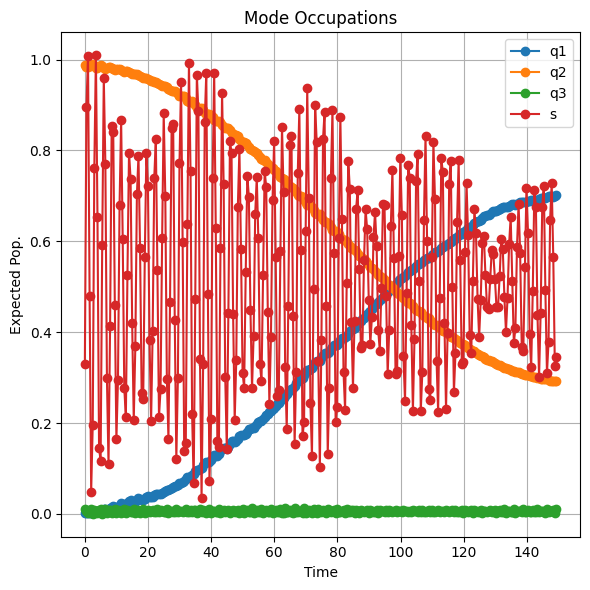

In [110]:
def propagate(
    n_periods, pulse_frequency, amplitude, snail, qs, rho0, c_ops, args, opts
):
    T = 2 * np.pi / pulse_frequency
    period_time = np.linspace(0, T, 250)
    pulse = Pulse(omega=pulse_frequency, amp=amplitude)
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail, n_max=None)
    H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
    U_ts = qt.propagator(H, period_time, c_ops, args=args, options=opts)
    U_t = U_ts[-1]
    full_time = np.linspace(0, n_periods * T, n_periods)
    occupations = {mode: np.zeros(len(full_time)) for mode in qs.modes_num}
    rho_tt = rho0
    for idx, t in tqdm(enumerate(full_time)):
        rho_tt = qt.Qobj(U_t * rho_tt * U_t.dag())
        for mode in qs.modes_num:
            occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))
    return full_time, occupations, rho_tt


def plot_propagation(full_time, occupations):
    # Setup the figure and axes for subplots
    fig, axs = plt.subplots(1, 1, figsize=(6, 6))

    # Plotting full time evolution over 20 periods
    for mode, occ in occupations.items():
        axs.plot(full_time, occ, label=mode.name, marker="o")

    axs.set_title("Mode Occupations")
    axs.set_xlabel("Time")
    axs.set_ylabel("Expected Pop.")
    axs.legend()
    axs.grid(True)
    fig.tight_layout()
    # fig.show()
    return


def extract_fidelity(final_state, qubits, expected_qubit_rho):
    qubit_rhof = final_state.ptrace(range(len(qubits)))
    return qt.fidelity(qubit_rhof, expected_qubit_rho)


# Now call the propagate function with all parameters
time_list, occs, final_state = propagate(
    300, wp + 0.0535, 14.15, snail, qs, rho0, c_ops, args, opts
)

# Plot the propagation results
plot_propagation(time_list, occs)

# Extract and print the fidelity of the final state
fidelity = extract_fidelity(final_state, qubits, expected_qubit_rho)
print("Fidelity of the final state:", fidelity)

In [83]:
def propagate_for_optimization(
    pulse_frequency, amplitude, snail, qs, rho0, c_ops, args, opts
):
    T = 2 * np.pi / pulse_frequency
    period_time = np.linspace(0, T, 250)
    n_periods = int(np.floor(150 / T))
    pulse = Pulse(omega=pulse_frequency, amp=amplitude)
    H_pump = qs.hamiltonian.driven_term(snail_mode=snail, n_max=None)
    H = [qs.hamiltonian.H0, [H_pump, pulse.drive]]
    U_ts = qt.propagator(H, period_time, c_ops, args=args, options=opts)
    U_t = U_ts[-1]
    full_time = np.linspace(0, n_periods * T, n_periods)
    # occupations = {mode: np.zeros(len(full_time)) for mode in qs.modes_num}
    rho_tt = rho0
    for idx, t in enumerate(full_time):
        rho_tt = qt.Qobj(U_t * rho_tt * U_t.dag())
        # for mode in qs.modes_num:
        #     occupations[mode][idx] = np.abs(qt.expect(qs.modes_num[mode], rho_tt))
    return rho_tt


def objective_function(
    x, snail, qs, rho0, c_ops, args, opts, qubits, expected_qubit_rho
):
    pulse_frequency, amplitude = x
    final_state = propagate_for_optimization(
        pulse_frequency, amplitude, snail, qs, rho0, c_ops, args, opts
    )
    fidelity = extract_fidelity(final_state, qubits, expected_qubit_rho)
    return 1 - fidelity


def callback(intermediate_result):
    x = intermediate_result.x
    current_fidelity = 1 - intermediate_result.fun
    print(
        f"Current params: pulse_frequency={x[0]}, amplitude={x[1]} - Current Fidelity: {current_fidelity}"
    )


# Example usage in optimization:
ret = minimize(
    fun=objective_function,
    x0=[wp + 0.0535, 14.15],
    args=(snail, qs, rho0, c_ops, args, opts, qubits, expected_qubit_rho),
    # bounds=[(wp - 0.2, wp + 0.2), (0, 20)],
    callback=callback,
    method="Nelder-Mead",
)

Current params: pulse_frequency=12.619870614359172, amplitude=14.857500000000002 - Current Fidelity: 0.8720673082964364
Current params: pulse_frequency=12.619870614359172, amplitude=14.857500000000002 - Current Fidelity: 0.8720673082964364
Current params: pulse_frequency=12.619870614359172, amplitude=14.857500000000002 - Current Fidelity: 0.8720673082964364
Current params: pulse_frequency=12.619870614359172, amplitude=14.857500000000002 - Current Fidelity: 0.8720673082964364
Current params: pulse_frequency=12.619870614359172, amplitude=14.857500000000002 - Current Fidelity: 0.8720673082964364
Current params: pulse_frequency=12.619870614359172, amplitude=14.857500000000002 - Current Fidelity: 0.8720673082964364
Current params: pulse_frequency=12.62233543283854, amplitude=14.413930664062502 - Current Fidelity: 0.8779134179071828
Current params: pulse_frequency=12.625416455937748, amplitude=14.566968994140627 - Current Fidelity: 0.8791427089704436
Current params: pulse_frequency=12.627881

In [78]:
# time_list, occs, final_state = propagate(20, wp + 0.1, 10)
# plot_propagation(time_list, occs)
# extract_fidelity(final_state)


# want to maximize fidelity by varying pulse frequency and amplitude
# fixed pulse duration to (~100 ns),
# I think my units are currently messed up so fix this to 10dt


def simulation_task(freq_amp_pair):
    freq, amp = freq_amp_pair  # Unpack the tuple
    T = 2 * np.pi / freq
    target_len = 10  # dt?
    n_periods = int(target_len / T)
    time_list, occs, final_state = propagate(n_periods, freq, amp)
    fidelity = extract_fidelity(final_state)
    return fidelity


# define the parameter space to sweep
N = 20
# frequencies will be detuned from abs(qubit1.freq - qubit2.freq)
detuning_rads = 2 * np.pi * np.linspace(-0.05, 0.05, N)  # Detuning in rad/s
flist = detuning_rads + wp
# alist = np.linspace(0, 40, 1)
alist = [30]

# Prepare the parameters for parallel execution
freq_amp_pairs = [(f, a) for f in flist for a in alist]

# Run the simulations in parallel
results = map(simulation_task, freq_amp_pairs)

# # Process results
# fidelities = np.array(results)

# # Reshape the results into the shape of the amplitude and detuning grid
# fidelity_matrix = fidelities.reshape(N, N)

# # Create meshgrid for the axes
# freq_mesh, amp_mesh = np.meshgrid(detuning_rads, alist, indexing="ij")

# # Plotting the heatmap
# plt.figure(figsize=(10, 8))
# heatmap = plt.pcolormesh(
#     freq_mesh, amp_mesh, fidelity_matrix.T, shading="auto", cmap="viridis"
# )
# plt.colorbar(heatmap)
# plt.title("Fidelity by Frequency and Amplitude")
# plt.xlabel("Detuning (rad/s)")
# plt.ylabel("Amplitude")
# plt.show()

In [79]:
results

In [80]:
list(results)

380it [00:00, 8218.61it/s]
380it [00:00, 8780.11it/s]
380it [00:00, 9032.99it/s]
380it [00:00, 8255.14it/s]
380it [00:00, 8708.58it/s]
380it [00:00, 9708.39it/s]
380it [00:00, 9468.29it/s]
380it [00:00, 8669.12it/s]
380it [00:00, 8229.22it/s]
380it [00:00, 8143.91it/s]
400it [00:00, 9025.54it/s]
400it [00:00, 9028.89it/s]
400it [00:00, 9069.94it/s]
400it [00:00, 8944.13it/s]
400it [00:00, 9647.57it/s]
400it [00:00, 9169.98it/s]
400it [00:00, 9208.49it/s]
400it [00:00, 9245.94it/s]
400it [00:00, 8562.69it/s]
400it [00:00, 8698.45it/s]


[0.24528846600706816,
 0.2915255734286506,
 0.1710405972289008,
 0.1933584088414502,
 0.38541857129605045,
 0.437795838457594,
 0.2835860228480245,
 0.3088741634055343,
 0.2543898086238179,
 0.5436579980022341,
 0.25376447616083697,
 0.48432703624499124,
 0.3740997385345227,
 0.2512814614089078,
 0.2347041406615877,
 0.2750537026697993,
 0.29621318888076686,
 0.3171709229983334,
 0.1936623340258925,
 0.14791562819283333]